In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/train.csv')

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

#Overview

There are 1460 instances of training data and 1460 of test data. Total number of attributes equals 81, of which 36 is quantitative, 43 categorical + Id and SalePrice.

*Quantitative*: 1stFlrSF, 2ndFlrSF, 3SsnPorch, BedroomAbvGr, BsmtFinSF1, BsmtFinSF2, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, EnclosedPorch, Fireplaces, FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, HalfBath, KitchenAbvGr, LotArea, LotFrontage, LowQualFinSF, MSSubClass, MasVnrArea, MiscVal, MoSold, OpenPorchSF, OverallCond, OverallQual, PoolArea, ScreenPorch, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd, YrSold

*Qualitative*: Alley, BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond, ExterQual, Exterior1st, Exterior2nd, Fence, FireplaceQu, Foundation, Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating, HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig, LotShape, MSZoning, MasVnrType, MiscFeature, Neighborhood, PavedDrive, PoolQC, RoofMatl, RoofStyle, SaleCondition, SaleType, Street, Utilities, 

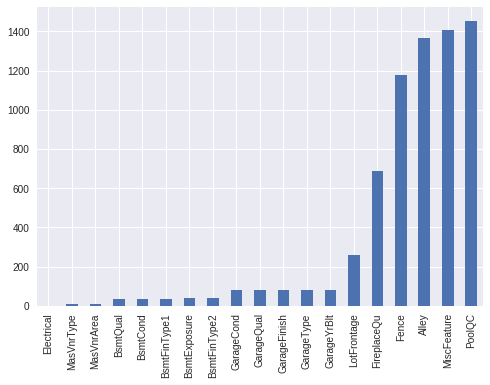

In [2]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

19 attributes have missing values, 5 over 50% of all data. Most of times NA means lack of subject described by attribute, like missing pool, fence, no garage and basement.

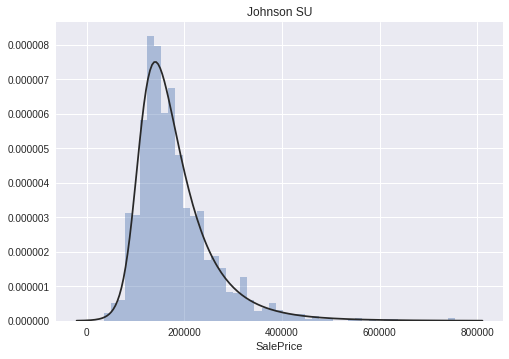

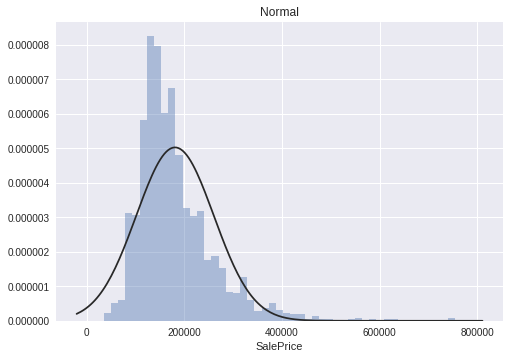

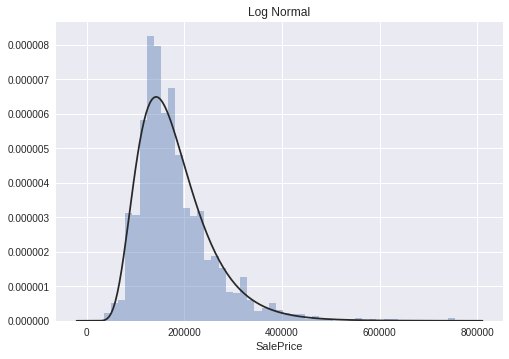

In [3]:
import scipy.stats as st
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

It is apparent that SalePrice doesn't follow normal distribution, so before performing regression it has to be transformed. While log transformation does pretty good job, best fit is unbounded Johnson distribution.

In [4]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


Also none of quantitative variables has normal distribution so these should be transformed as well.

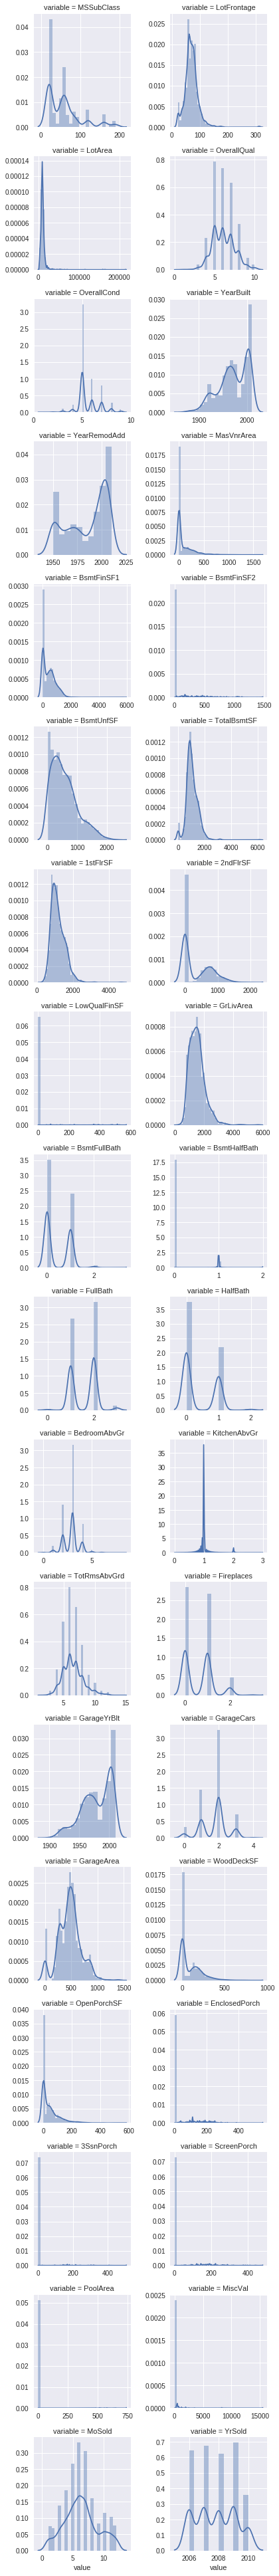

In [5]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

Some independent variables look like good candidates for log transformation: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea and others. While ganining on regression transformation will smooth out some irregularities which could be important like large amount of houses with 0 2ndFlrSF. Such irregularities are good candidates for feature construction.

#Categorical data

With qualitative variables we can implement two methods. First one is to check distribution of SalePrice with respect to variable values and enumerate them. Second to create dummy variable for each possible category.

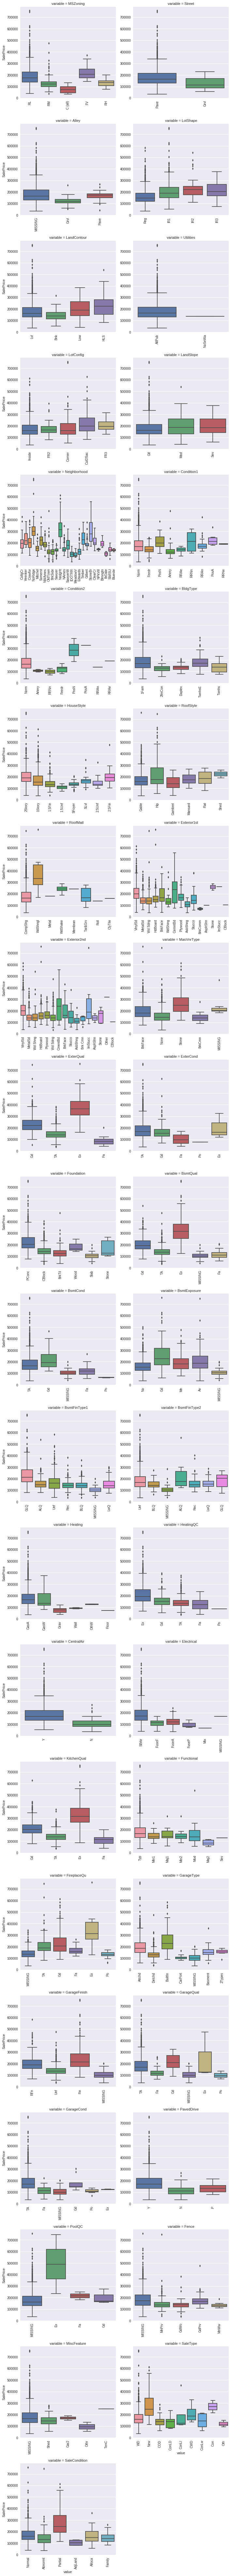

In [6]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

Some categories seem to more diverse with respect to SalePrice than others. Neighborhood has big impact on house prices. Most expensive seems to be Partial SaleCondition. Having pool on property seems to improve price substantially. There are also differences in variabilities between category values.

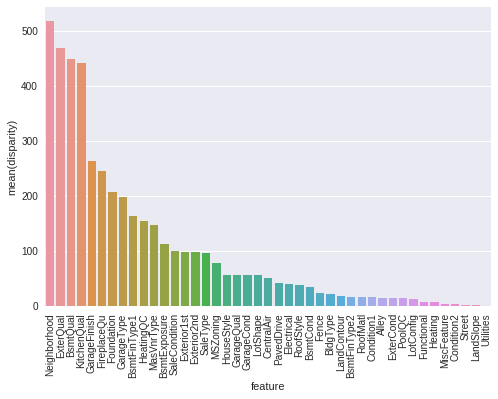

In [7]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

Here is quick estimation of influence of categorical variable on SalePrice. For each variable SalePrices are partitioned to distinct sets based on category values. Then check with ANOVA test if sets have similar distributions. If variable has minor impact then set means should be equal. Decreasing pval is sign of increasing diversity in partitions.

In [8]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


Now qualitative variables get encoded according to ordering based on mean of SalePrice.

#Correlations

Generally to reduce confunding only variables uncorrelated with each other should be added to regression models (which are correlated with SalePrice).

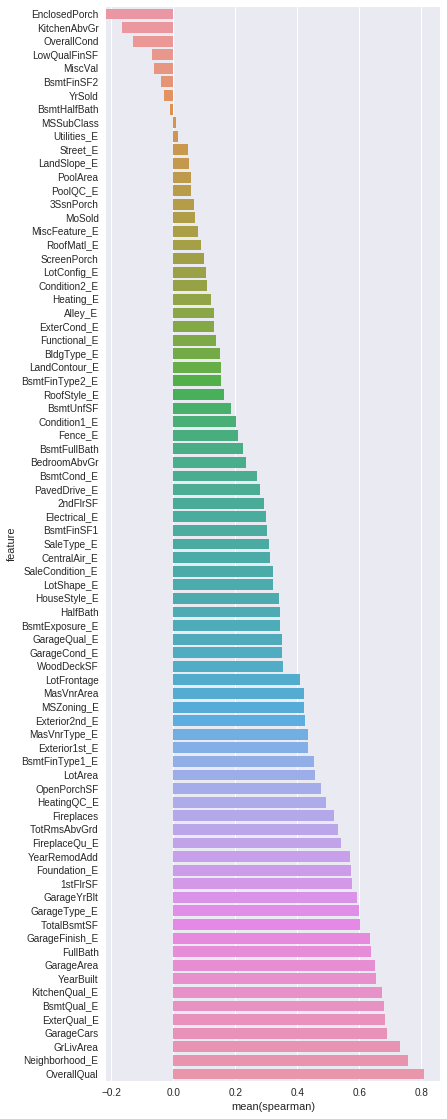

In [9]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(train, features)

Spearman correlation is better to work with in this case because it picks up relationships between variables even when they are nonlinear. OverallQual is main criterion in establishing house price. Neighborhood has big influence, partially it has some intrisinc value in itself, but also houses in certain regions tend to share same characteristics (confunding) what causes similar valuations.

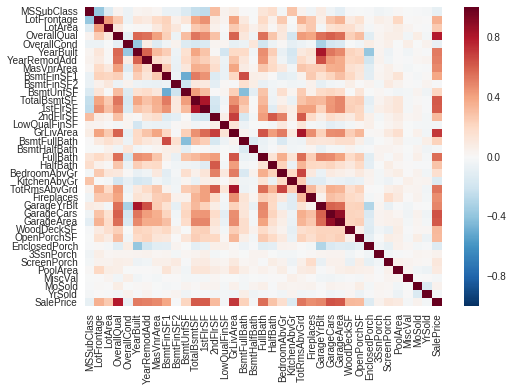

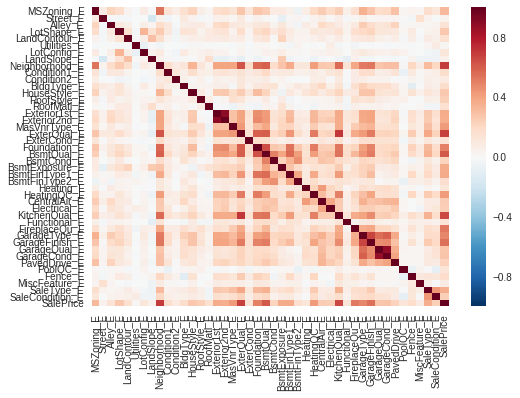

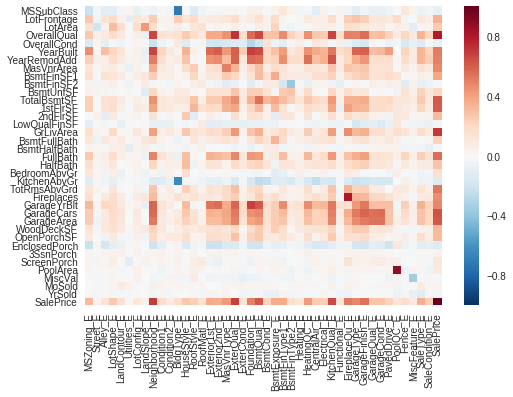

In [10]:
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

There are many strong correlations between variables. Garages seem to be built same year as houses, basements have generally same area as first floor which is pretty obvious. Garage area is strongly correlated with number of cars. Neighborhood is correlated with lots of other variables and this confirms the idea that houses in same region share same characteristics. Dwelling type is negatively correlated with kitchen above grade square feet. 

#Pairplots

It also would be useful to see how sale price compares to each independent variable.

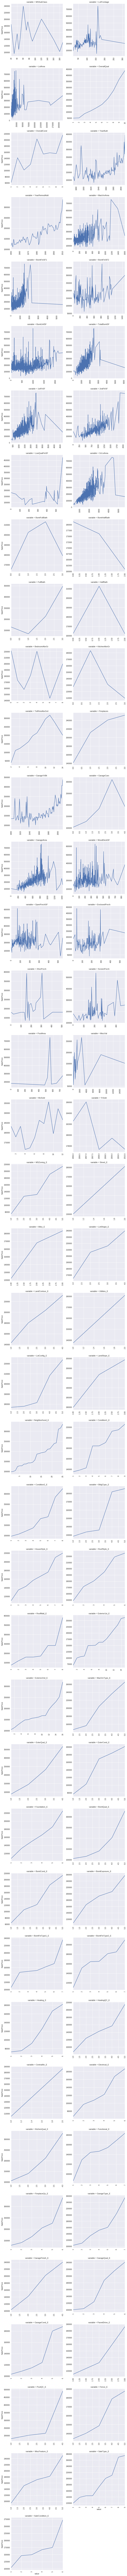

In [11]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=['SalePrice'], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")

There are lots of nonlinearities this may be the cause why some variables wont be selected by Lasso/Lars. Some factors like YearBuilt, 1stFlrSF, 2ndFlrSF, Neighborhood_E look like they would benefit from adding quadratic term to regression. But on the other hand this will most probably provoke overfit.

# Price Segments

It is possible that correlations shift with change of SalePrice.

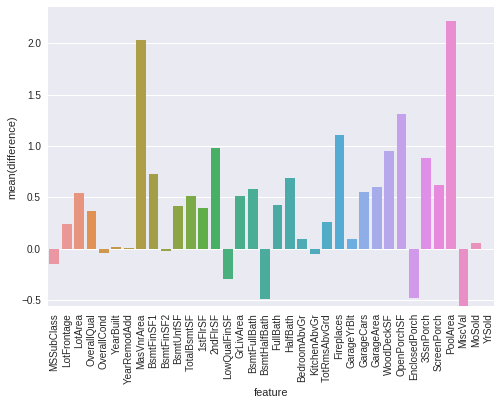

In [12]:
features = quantitative

standard = train[train['SalePrice'] < 200000]
pricey = train[train['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]

sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

Here houses are divided in two price groups: cheap (under 200000) and expensive. Then means of quantitative variables are compared. Expensive houses have pools, better overall qual and condition, open porch and increased importance of MasVnrArea.

#Clustering

0.749800450272


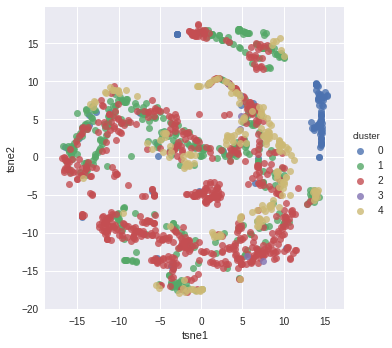

In [13]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

30 First PCA Components explain 75% of variance. There seems to be some clustering present but it is not enough for segmented regression.

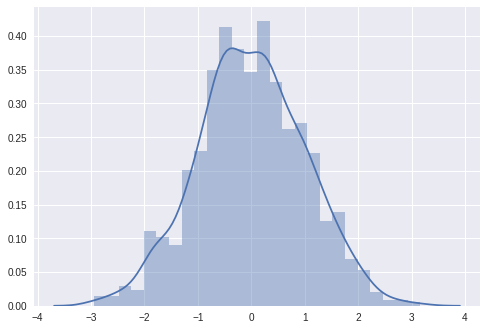

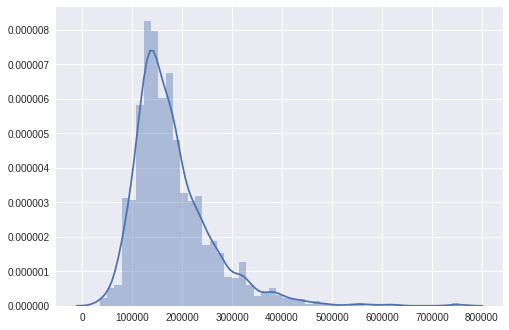

In [14]:
y = train['SalePrice'].values
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)

Here is Johnson Transform of SalePrice. I tried Box Cox, Fisher and Johnson transforms but none of these can beat log in simple linear regression. It is probably because they have tunable parameters that overfit to training data. If there were much more than 1500 instances they could be alternative to log transformation.

# Regression

In [15]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    train[feature+'2'] = train[feature]**2
    
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']


features = quantitative + qual_encoded + boolean + qdr
lasso = linear_model.LassoLarsCV(max_iter=10000)
X = train[features].fillna(0.).values
Y = train['SalePrice'].values
lasso.fit(X, np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y, Ypred)

0.10968604106630647

Adding quadratic terms improves local score but behaves unstable on LB.

In [16]:
import patsy

Y, X = patsy.dmatrices(
    "SalePrice ~ \
        GarageCars + \
        np.log1p(BsmtFinSF1) + \
        ScreenPorch + \
        Condition1_E + \
        Condition2_E + \
        WoodDeckSF + \
        np.log1p(LotArea) + \
        Foundation_E + \
        MSZoning_E + \
        MasVnrType_E + \
        HouseStyle_E + \
        Fireplaces + \
        CentralAir_E + \
        BsmtFullBath + \
        EnclosedPorch + \
        PavedDrive_E + \
        ExterQual_E + \
        bs(OverallCond, df=7, degree=1) + \
        bs(MSSubClass, df=7, degree=1) + \
        bs(LotArea, df=2, degree=1) + \
        bs(FullBath, df=3, degree=1) + \
        bs(HalfBath, df=2, degree=1) + \
        bs(BsmtFullBath, df=3, degree=1) + \
        bs(TotRmsAbvGrd, df=2, degree=1) + \
        bs(LandSlope_E, df=2, degree=1) + \
        bs(LotConfig_E, df=2, degree=1) + \
        bs(SaleCondition_E, df=3, degree=1) + \
        OverallQual + np.square(OverallQual) + \
        GrLivArea + np.square(GrLivArea) + \
        Q('1stFlrSF') + np.square(Q('1stFlrSF')) + \
        Q('2ndFlrSF') + np.square(Q('2ndFlrSF')) +  \
        TotalBsmtSF + np.square(TotalBsmtSF) +  \
        KitchenAbvGr + np.square(KitchenAbvGr) +  \
        YearBuilt + np.square(YearBuilt) + \
        Neighborhood_E + np.square(Neighborhood_E) + \
        Neighborhood_E:OverallQual + \
        MSSubClass:BldgType_E + \
        ExterQual_E:OverallQual + \
        PoolArea:PoolQC_E + \
        Fireplaces:FireplaceQu_E + \
        OverallQual:KitchenQual_E + \
        GarageQual_E:GarageCond + \
        GarageArea:GarageCars + \
        Q('1stFlrSF'):TotalBsmtSF + \
        TotRmsAbvGrd:GrLivArea",
    train.to_dict('list'))

ridge = linear_model.RidgeCV(cv=10)
ridge.fit(X, np.log(Y))
Ypred = np.exp(ridge.predict(X))
print(error(Y,Ypred))

0.11602320727290623


This gives better local score, but on LB is ~12.6. However it looks that dividing some variables into splines gives some improvement.